# Tutorial Overview
This set of two tutorials (running and analyzing) will explain the UncertaintyForest class. After following both tutorials, you should have the ability to run the code on your own machine and interpret the results. 

If you haven't seen it already, take a look at other tutorials to setup and install the progressive learning package `Installation-and-Package-Setup-Tutorial.ipynb`

# Analyzing the UncertaintyForest Class by Reproducing Figure 1
## *Goal: Run the UncertaintyForest class to produce the results from Figure 1*
*Note: Figure 1 refers to Figure 1 from [this paper](https://arxiv.org/pdf/1907.00325.pdf)*

### First, we'll import the necessary packages that will be required

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from proglearn.forest import UncertaintyForest
from proglearn.sims import generate_gaussian_parity

### Next, we'll define a simple function that will generate the data that figure 1 was produced with

In [2]:
def generate_data(n, mean, var):
    '''
    Parameters
    ---
    n : int
        The number of data to be generated
    mean : double
        The mean of the data to be generated
    var : double
        The variance in the data to be generated
    '''
    y = 2 * np.random.binomial(1, .5, n) - 1 # classes are -1 and 1.
    X = np.random.multivariate_normal(mean * y, var * np.eye(n), 1).T # creating the X values using 
    # the randomly distributed y that were generated in the line above
    
    return X, y

### Now, we'll define a function that will estimate the posteriors. (This is what the left three plots in figure 1 displays)

In [3]:
def estimate_posterior(algo, n, mean, var, num_trials, X_eval, parallel = False):
    '''
    Estimate posteriors for many trials and evaluate in the given X_eval range
    
    Parameters
    ---
    algo : dict
        A dictionary of the learner to be used containing a key "instance" of the learner
    n : int
        The number of data to be generated
    mean : double
        The mean of the data used
    var : double
        The variance of the data used
    num_trials : int
        The number of trials to run over
    X_eval : list
        The range over which to evaluate X values for
    '''
    obj = algo['instance'] # grabbing the instance of the learner 
    def worker(t):
        X, y = generate_data(n, mean, var) # generating data with the function above
        obj.fit(X, y) # using the fit function of the learner to fit the data
        return obj.predict_proba(X_eval)[:,1] # using the predict_proba function on the range of desired X
        
    if parallel:
        predicted_posterior = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_posterior = np.zeros((num_trials, X_eval.shape[0]))
        for t in tqdm(range(num_trials)):
            predicted_posterior[t, :] = worker(t)

    return predicted_posterior

### Now, we'll define a function that will plot the posteriors and variance. (This is what generates the plots in figure 1 )

In [4]:
def plot_posterior(ax, algo, num_plotted_trials, X_eval):
    """
    Will be used for CART, Honest, or Uncertainty Forest to plot P(Y = 1 | X = x). 
    This is the left three plots in figure 1.
    Plots each of num_plotted_trials iterations, highlighting a single line
    
    Parameters
    ---
    ax : list
        Holds the axes of the subplots
    algo : dict
        A dictionary of the learner to be used containing a key "instance" of the learner
    num_plotted_trials : int
        The number of trials that will be overlayed. This is shown as the lighter lines figure 1.
    X_eval : list
        The range over which to evaluate X values for
    """
    for i in range(num_plotted_trials):
        linewidth = 1
        opacity = .3
        if i == num_plotted_trials - 1:
            opacity = 1
            linewidth = 8
        ax.set_title(algo['title'])
        ax.plot(X_eval.flatten().ravel(), algo['predicted_posterior'][i, :].ravel(), 
                label = algo['label'],
                linewidth = linewidth, 
                color = algo['color'], 
                alpha = opacity)


def plot_variance(ax, algos, X_eval):
    """
    Will be used for the rightmost plot in figure 1.
    Plots the variance over the number of trials.
    
    Parameters
    ---
    ax : list
        Holds the axes of the subplots
    algos : list
        A list of dictionaries of the learners to be used
    X_eval : list
        The range over which to evaluate X values for
    """
    ax.set_title('Posterior Variance') # adding a title to the plot
    for algo in algos: # looping over the algorithms used
        variance = np.var(algo['predicted_posterior'], axis = 0) # determining the variance
        ax.plot(X_eval.flatten().ravel(), variance.ravel(), 
                label = algo['label'],
                linewidth = 8, 
                color = algo['color']) # plotting

### Now, this is a function that will call the above functions to actually create figure 1

In [5]:
def plot_fig1(algos, num_plotted_trials):
    """
    Sets the communal plotting parameters and creates figure 1

    Parameters
    ---
    algos : list
        A list of dictionaries of the learners to be used
    num_plotted_trials : int
        The number of trials that will be overlayed. This is shown as the lighter lines figure 1.
    """
    sns.set(font_scale = 6) # setting font size
    sns.set_style("ticks") # setting plot style
    plt.rcParams['figure.figsize'] = [55, 14] # setting figure size
    fig, axes = plt.subplots(1, 4) # creating the axes (that will be passed to the subsequent functions)
    for ax in axes[0:3]:
        ax.set_xlim(-2.1, 2.1) # setting x limits
        ax.set_ylim(-0.05, 1.05) # setting y limits

    # Create the 3 posterior plots. (Left three plots in figure 1)
    for i in range(len(algos)):
        plot_posterior(axes[i], 
                       algos[i],
                       num_plotted_trials, 
                       X_eval)

    # Create the 1 variance plot. (Rightmost plot in figure 1)
    plot_variance(axes[3], algos, X_eval)
    
    fig.text(0.5, .08, 'x', ha='center') # defining the style of the figure text
    axes[0].set_ylabel(r"$\hat P(Y = 1|X = x)$") # labeling the axes
    axes[0].set_xlabel(" ")
    axes[3].set_ylabel(r"Var($\hat P(Y = 1|X = x)$)")
    
    fig.tight_layout()
    plt.savefig("fig1.pdf")
    plt.show()

### Now, we'll specify some parameters and actually run the functions we've set above.

In [6]:
# The following are two sets of parameters.
# The first are those that were actually used to produce figure 1.
# These take a long time to actually run since there are 6000 data points.
# Below those, you'll find some testing parameters so that you can see the results quicker.

# Here are the "Real Parameters"
#n = 6000
#mean = 1
#var = 1
#num_trials = 100 
#X_eval = np.linspace(-2, 2, num = 30).reshape(-1, 1)
#n_estimators = 300
#num_plotted_trials = 10

# Here are the "Test Parameters"
n = 300 # number of data points
mean = 1 # mean of the data
var = 1 # variance of the data
num_trials = 3 # number of trials to run
X_eval = np.linspace(-2, 2, num = 10).reshape(-1, 1) # the evaluation span (over X) for the plot
n_estimators = 200 # the number of estimators
num_plotted_trials = 2 # the number of "fainter" lines to be displayed on the figure

# Algorithms used to produce figure 1
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators // 5), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Plotting parameters
parallel = True

In [7]:
# This is the code that actually generates data and predictions.
for algo in algos:
    algo['predicted_posterior'] = estimate_posterior(algo, n, mean, var, num_trials, X_eval, parallel = parallel)
    
with open('algos_fig1.pkl', 'wb') as f:
    pickle.dump(algos, f)

### Now, create figure 1.

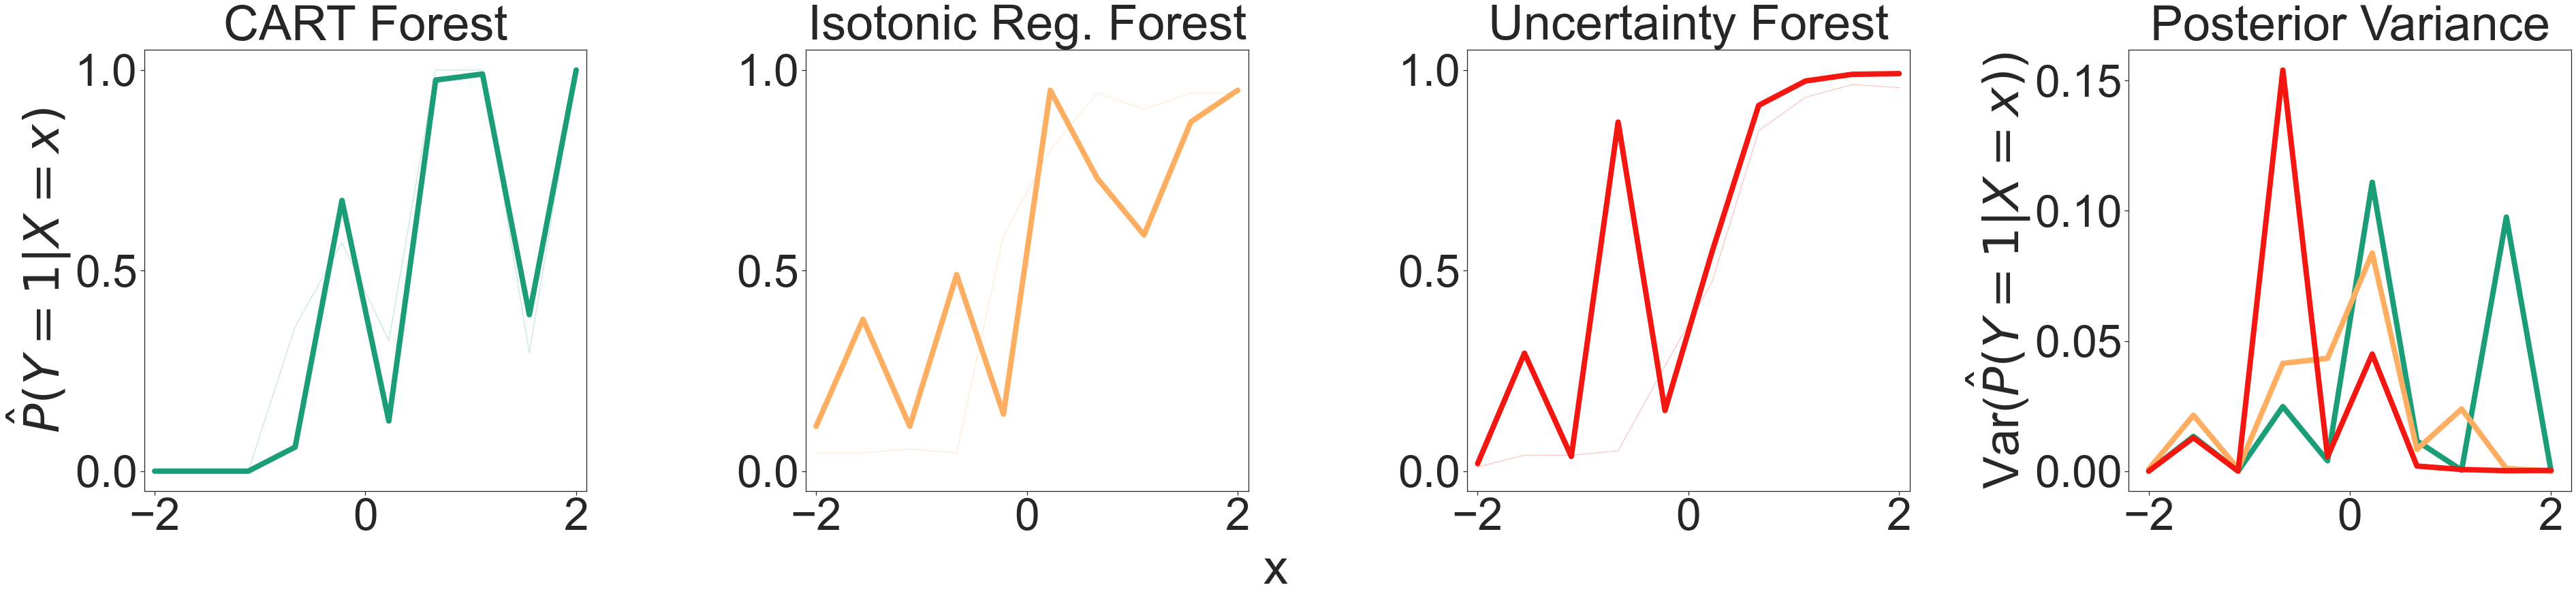

In [8]:
with open('algos_fig1.pkl', 'rb') as f:
    algos = pickle.load(f)
    
plot_fig1(algos, num_plotted_trials)